$$\LARGE \text{Integrazione ``alla Gauss'' }$$

I metodi discussi finora per calcolare l'integrale definito di una funzione tra due limiti di integrazione (metodo dei trapezi e metodo di Simpson) sono basati sulla possibilita' di calcolare il valore della funzione integranda su una serie di punti equispaziati comprendenti i limiti di integrazione. 

Se pero' la funzione integranda diverge (va verso $\pm \infty$) su uno di questi bordi (pur rimanendo integrabile), sorge il problema di quale valore attribuirgli nelle nostre formule. Sarebbe quindi utile trovare un modo per calcolare l'integrale in modo non vincolato ai valori della funzione ai punti di bordo. 

Il **metodo di Gauss** va in questa direzione e permette di calcolare accuratamente integrali anche per polinomi di grado elevato usando i valori che la funzione assume in una serie di punti (piu' o meno numerosi) scelti senza la  richiesta che siano equispaziati e senza includere i limiti di ntegrazione. Il metodo si basa sulla possibilita' di esprimere l'integrale come sommatoria di un numero $n$ di termini:

$$\int_a^b f(x) dx \simeq \sum_{i=1}^n w_i ~f(x_i) $$

con $w_i$ coefficienti (o pesi) opportunamente scelti per soddisfare l'uguaglianza. La possibilita' di avere diversi valori per $a, b, x_i, w_i$ determina le caratteristiche della formula di integrazione. 
Se l'intervallo di integrazione e' limitato tra $a=-1, b=+1$ e' possibile usare l'integrazione di Gauss-Legendre di ordine $n$ in cui le $x_i$ sono gli zeri di un polinomio di Legendre di ordine $n$ e gli $w_i=1$ sono i corrispondenti pesi da adottare. 


# Zeri dei polinomi di Legendre

Partiamo dalla espressione dei primi 6 polinomi di Legendre:

-  $P_0  =1$ 
-  $P_1  =x$ 
-  $P_2  =1/2~(3x^2-1)$ 
-  $P_3  =1/2~(5x^3-3x)$ 
-  $P_4  =1/8~(35x^4-30x^2+3)$ 
-  $P_5  =1/8~(63x^5-70x^3+15x)$  

Notiamo subito che $P_0$ non ha zeri, mentre $P_1$ ha uno zero in (x=0). Se andiamo al $P_2$ troviamo che e' zero per  $x=-1/\sqrt{3}$ ed $x=+1/\sqrt{3}$.  Se li grafichiamo tutti insieme tra i limiti -1<x<1 possiamo strimare "ad occhio" gli zeri guardando alle intersezioni tra i vari polinomi e l'asse $y=0$:

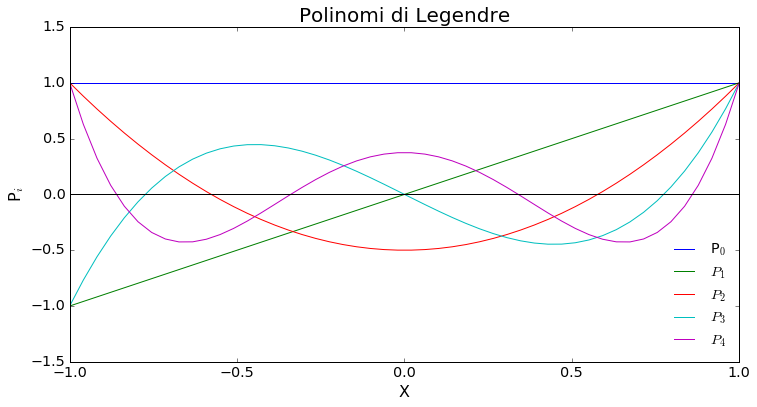

In [50]:
# Facciamo un grafico per evidenziare il comportamento dei 
# primi cinque polinomi di Legendre: 

import matplotlib.pyplot as plt
npunti=50
xtest=np.linspace(-1,1,npunti)  # definisco n coordinate 
                                # nell'intervallo (-1,1)
# assegno i valori assunti dai polinomi nei punti "npunti"
P0 =np.ones(npunti)             # grado 0
P1 =xtest                       # grado 1 
P2 =1/2.*(3*xtest**2 - 1)       # ...ecc...ecc...
P3 =1/2.*(5*xtest**3 - 3*xtest) 
P4 =1/8.*(35*xtest**4 - 30*xtest**2+3) 
P5 =1/8.*(63*xtest**5 - 70*xtest**3+15*xtest) 

# vado a graficare i vari set di punti:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(xtest,P0,label='P$_0$')
plt.plot(xtest,P1,label='$P_1$')
plt.plot(xtest,P2,label='$P_2$')
plt.plot(xtest,P3,label='$P_3$')
plt.plot(xtest,P4,label='$P_4$')
plt.plot(xtest,np.zeros(npunti),'black')
plt.title('Polinomi di Legendre',fontsize=20)
plt.xlabel('X',fontsize=16)
plt.ylabel('P$_i$',fontsize=16)
plt.axis([-1, 1, -1.5, +1.5])
plt.legend(loc='lower right',frameon=False)
plt.savefig("foo.pdf")
plt.show()



# Nodi e pesi dei polinomi 
Ora vogliamo calcolare le $x_i$ che ci servono per integrare "alla Gauss-Legendre" la nostra funzione. Per questo sviluppiamo una funzione, che chiameremo **gaussNodes**, per calcolare le ascisse dei nodi (ed i corrispondenti pesi) che sono necessari nell'integrazione di Gauss-Legendre. Ricordiamo anche che con questo approccio l'intervallo di integrazione standardizzato e' **(−1, 1)**. 

Come primo passo introduciamo ora una funzione che ci permette di calcolare in modo approssimato gli zeri dei polinomi di Legendre. Si puo' dimostrare infatti (non qui) che una prima stima approssimata e' data dalla relazione:

$$ \large x_i = \cos \frac{\pi(i + 0.75)}{m+0.5}$$

dove con $\large m=n+1$ abbamo indicato il numero di nodi ed $\large n$ e' il grado del polinomio che vogliamo usare. Il numero intero $\large m$ e' anche detto **ordine di integrazione**. I valori che calcoliamo cosi' ci servono come valori di partenza per poi calcolare il valore esatto delle ascisse dei nodi usando il metodo di Newton-Raphson. Questo metodo, che serve per la ricerca degli zeri di una funzione, per ora lo assumiamo. Ci riserviamo tuttavia di discuterlo piu' dettaglio nel seguito quando ci renderemo meglio conto del perche' abbiamo la necessita' di fare una stima di primo avvicinamento al valore $x_i$ cercato. 

In [14]:
# una possibile implementazione dell'integrazione alla Gauss-Legendre:
import math
import numpy as np
def gaussNodes(m,tol=10e-9):
    ''' CALL  : x,A = gaussNodes(m,tol=10e-9)
        INP   : m     numero di punti da usare nella quadratura 
        OUT   : x, A  ascisse {x_i} ed pesi corrispondenti {A_i} dei nodi
                      per la quadratura di Gauss-Legendre ad m-punti
    '''
    def legendre(t,m):
        """
        Calcola il valore del polinomio di Legendre di grado m e della
        sua derivata nel punto t. I valori di t sono passati dal 
        programma chiamante inizialmente come stima approssimata dalla 
        formula: 
           t = cos(pi*(i + 0.75)/(m + 0.5))    (eq.1.31 degli appunti)
        e poi come successivi avvicinamenti allo zero richiesto che 
        vengono determinati dal programma chiamante con il metodo di 
        Newton-Raphson. 
        INP:   t     posizione alla quale calcolare il valore del polinomio 
               m     ordine del polinomio   
               
        OUT    p,dp  sono: il valore che assume, nella posizione x=t, 
                     il polinomio di ordine m e la sua derivata. Il 
                     calcolo usa le formule di ricorrenza (eq.(1.28, 
                     ed 1.30) degli appunti). Questi valori verranno 
                     poi usati nel programma chiamante (che e' GaussNodes) 
                     per trovare gli zeri (i nodi) con l'accuratezza 
                     del metodo di Newton-Raphson (che richiede di 
                     avere il valore della funzione e della sua derivata).
        """
        p0 = 1.0; p1 = t
        for k in range(1,m):
            # dalla relazione 1.28 degli appunti (con k=n+1):
            p = ((2.0*k + 1.0)*t*p1 - k*p0)/(1.0 + k )
            p0 = p1; p1 = p
        # dalla relazione 1.30 degli appunti abbiamo la derivata   
        dp = m*(p0 - t*p1)/(1.0 - t**2)   
        return p,dp

    A = np.zeros(m)
    x = np.zeros(m)
    nRoots = int((m + 1)/2)        # Numero di radici non-negative  
    for i in range(nRoots):        # ciclo sulle radici positive 
        # prima di entrare nel ciclo che determina lo zero 
        # usiamo la eq.(1.31) degli appunti per avere una prima 
        # stima dello zero i-esimo del polinomio
        t = math.cos(math.pi*(i + 0.75)/(m + 0.5))  
        # nel for seguente calcolo zeri e derivate del polinomio di 
        # ordine m usando Newton-Raphson  (eq.1.37 degli appunti) per 
        # trovare lo zero del polinomio in modo piu' accurato:
        for j in range(30):
            p,dp = legendre(t,m)   
            dt = -p/dp; t = t + dt   
            # se il dt calcolato e' minore della tolleranza:
            if abs(dt) < tol:      
                x[i] = t; x[m-i-1] = -t # registro la posizione x  del nodo
                                        # i-esimo e del suo simmetrico;
                A[i] = 2.0/(1.0 - t**2)/(dp**2) # peso da attribuire (eq.
                                                # (1.29) al punto x(i) ed 
                A[m-i-1] = A[i]                 # al suo simmetrico.

                break
    return x,A

# integrazione alla Gauss
Definiamo ora un modulo che calcola la quadratura (cioe' fa l'integrale) usando i risultati del modulo precedente **gaussNodes** che fornisce in output posizioni e pesi dei nodi da usare:

In [15]:
# importa da gaussNodes posizioni e pesi dei nodi 
# per il polinomio di Legendre di grado n
def gaussQuad(f,a,b,m):
    ''' Computes the integral of f(x) from x = a to b
        with Gauss-Legendre quadrature using m nodes.
        CALL   : I = gaussQuad(f,a,b,m).
        INP    : f     funzione integranda
                 a,b   limiti di integrazione
                 m     ordine del polinomio da usare
    METHOD : per trasformare i limiti di integrazione da un 
             generico intervallo [a,b] all'intervallo [-1,+1] 
             si definiscono le costanti c1 e c2 che permettono 
             la conversione richiesta seguendo le indicazioni 
             date nell' eq(1.33) degli appunti.
    '''
    c1 = (b + a)/2.0  
    c2 = (b - a)/2.0
    x,A = gaussNodes(m)      # determino nodi e pesi 
    sum = 0.0
    for i in range(len(x)):  # vado a sommare sui nodi
        sum = sum + A[i]*f(c1 + c2*x[i])

    return c2*sum


## definiamo la funzione integranda
definisco ora una funzione di cui voglio calcolare l'integrale col metodo di Gauss-Legendre:

In [16]:
def f(x):
    return x*x*x

## eseguiamo ora gaussQuad 
inserendo i parametri di input:

In [17]:
gaussQuad(f,0,3,2)

20.249999478869793


# Integrazione alla Gauss - 2
### Vediamo un'altra possibile implementazione: 
Questa parte del notebook mostra una diversa implementazione dello stesso problema e fa vedere come sia possibile articolare il codice in modi diversi, ma sempre che portano al corretto risultato. 
**(prima del run verificare la definizione della funzione e dell'intervallo di integrazione)**


In [19]:
from numpy import *    # importo funzioni matematiche predefinite

##################################################################
# Recursive generation of the Legendre polynomial of order n
def Legendre(n,x):
    """ Dato l'ordine n del polinomio ed il punto in cui calcolarlo, 
        usa una regola di ricorrenza tra polinomi di Legendre: 
            n P_n = (2n-1)x P_{n-1} -(n-1) P_{n-2}
        La procedure chiama se stessa per sfruttare la ricorrenza
    INP   : n   ordine del polinomio  
            x   punto in cui calcolarlo 
    """
    x=array(x)
    if (n==0):
        return x*0+1.0
    elif (n==1):
        return x
    else:
        return ((2.0*n-1.0)*x*Legendre(n-1,x)-(n-1)*Legendre(n-2,x))/n

##################################################################
# Derivative of the Legendre polynomials
def DLegendre(n,x):
    x=array(x)
    if (n==0):
        return x*0
    elif (n==1):
        return x*0+1.0
    else:
        return (n/(x**2-1.0))*(x*Legendre(n,x)-Legendre(n-1,x))
##################################################################
# Roots of the polynomial obtained using Newton-Raphson method
def LegendreRoots(polyorder,tolerance=1e-10):  
    # si puo' richiedere una tolerance fino a 1e-20 !
    if polyorder<2:
        err=1 # bad polyorder no roots can be found
    else:
        roots=[]
        # The polynomials are alternately even and odd functions. 
        # So we evaluate only half the number of roots.
        for i in range(1,int(polyorder)//2 +1): # "//" fa la divisione
            x=cos(pi*(i-0.25)/(polyorder+0.5))  #  tra numeri interi
            error=10*tolerance
            iters=0
            while (error>tolerance) and (iters<1000):
                dx=-Legendre(polyorder,x)/DLegendre(polyorder,x)
                x=x+dx
                iters=iters+1
                error=abs(dx)
            roots.append(x)
        # Use symmetry to get the other roots
        roots=array(roots)
        if polyorder%2==0:
            roots=concatenate( (-1.0*roots, roots[::-1]) )
        else:
            roots=concatenate( (-1.0*roots, [0.0], roots[::-1]) )
        err=0 # successfully determined roots
    return [roots, err]
##################################################################
# Weight coefficients
def GaussLegendreWeights(polyorder):
    W=[]
    [xis,err]=LegendreRoots(polyorder)
    if err==0:
        W=2.0/( (1.0-xis**2)*(DLegendre(polyorder,xis)**2) )
        err=0
    else:
        err=1 # could not determine roots - so no weights
    return [W, xis, err]
##################################################################
# The integral value
# func                   : the integrand
# a, b                   : lower and upper limits of the integral
# polyorder          : order of the Legendre polynomial to be used
#
def GaussLegendreQuadrature(func, polyorder, a, b):
    [Ws,xs, err]= GaussLegendreWeights(polyorder)
    if err==0:
        ans=(b-a)*0.5*sum( Ws*func( (b-a)*0.5*xs+ (b+a)*0.5 ) )
    else:
        # (in case of error)
        err=1
        ans=None
    return [ans,err]
##################################################################
# The integrand - change as required
def func(x):
    return exp(x)
##################################################################
#

order=5
[Ws,xs,err]=GaussLegendreWeights(order)
if err==0:
    print ("Order    : ", order)
    print ("Roots    : ", xs)
    print ("Weights  : ", Ws)
else:
    print ("Roots/Weights evaluation failed")

# Integrating the function
[ans,err]=GaussLegendreQuadrature(func , order, -3,3)
if err==0:
    print ("Integral : ", ans)
else:
    print ("Integral evaluation failed")


Order    :  5
Roots    :  [-0.90617985 -0.53846931  0.          0.53846931  0.90617985]
Weights  :  [ 0.23692689  0.47862867  0.56888889  0.47862867  0.23692689]
Integral :  20.0355777184


## FINE